In [8]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy as sc
from scipy.fft import fft
from scipy.signal import filtfilt, sosfiltfilt, iirnotch, freqz, sosfreqz, tf2sos, butter, cheby1, cheby2, ellip, buttord, lfilter
plt.rcParams['figure.figsize'] = (15, 10)

In [9]:
def read_csv_file(filename='Ligo_GW_data.csv'):
    with open(filename, newline='') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        a1 = []
        a2 = []
        for row in csvreader:
            a1.append(float(row[1]))
            a2.append(float(row[2]))
    csvfile.close()
    return np.array(a1), np.array(a2)

def get_fft(f_s, signal):
    mag = np.abs(fft(signal))
    spectrum = np.fft.fftfreq(len(signal), d=1/f_s)      #d=1/f_s
    return spectrum, mag

def notch_filter_alpha(f_c, f_s, bw, signal):
    Q = f_c/bw
    b, a = iirnotch(f_c, Q, f_s)
    # sos = tf2sos(b, a)
    # filtered_signal = sosfiltfilt(sos, signal)
    filtered_signal = filtfilt(b, a, signal)
    W, H = freqz(b, a, fs=f_s)   #fs = f_s
    return filtered_signal, W, 20*np.log10(abs(H))   #W*f_s/(2*np.pi)

def notch_filter(f_c, f_s, Q, signal):
    b, a = iirnotch(f_c, Q, f_s)
    W, H = freqz(b, a, worN=2000)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal, W*f_s/(2*np.pi), 20*np.log10(abs(H))

def band_pass_filter_alpha(f_l, f_h, f_s, signal):
    order = 10
    ripple = 1
    sb = 40
    pb = 0.8
    # b, a = butter(order, [f_l/(f_s/2), f_h/(f_s/2)], btype='band')
    # sos = butter(order, [f_l/(f_s/2), f_h/(f_s/2)], btype='band', analog=False, output='sos', fs=f_s)
    sos = cheby1(order, ripple, [f_l, f_h], btype='band', analog=False, output='sos', fs=f_s)    #[f_l/(f_s/2), f_h/(f_s/2)]
    # b, a = ellip(order, pb, sb, [f_l/(f_s/2), f_h/(f_s/2)], btype='band')
    filtered_signal = sosfiltfilt(sos, signal)
    W, H = freqz(sos, fs=f_s)
    return filtered_signal, W*f_s/(2*np.pi), 20*np.log10(abs(H))   

def band_pass_filter_beta(order, f_l, f_h, f_s, signal):
    b, a = butter(order, [f_l, f_h], btype='band', fs=f_s)
    W, H = freqz(b, a, worN=2000, fs=f_s)  
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal, W, 20*np.log10(abs(H))

def band_pass_filter(order, ripple, f_l, f_h, f_s, signal):
    f_l = f_l/(f_s/2)
    f_h = f_h/(f_s/2)
    b, a = butter(order, [f_l, f_h], btype = 'bandpass', analog=False)
    # b, a = cheby1(order, ripple, [f_l, f_h], btype='bandpass', analog=False)
    W, H = freqz(b, a, worN=2000, fs=f_s)
    # filtered_signal = filtfilt(b, a, signal)
    filtered_signal = lfilter(b, a, signal)    #lfilter
    return filtered_signal, W, 20*np.log10(abs(H))

### Retrieving Data

7.706262192395323e-19


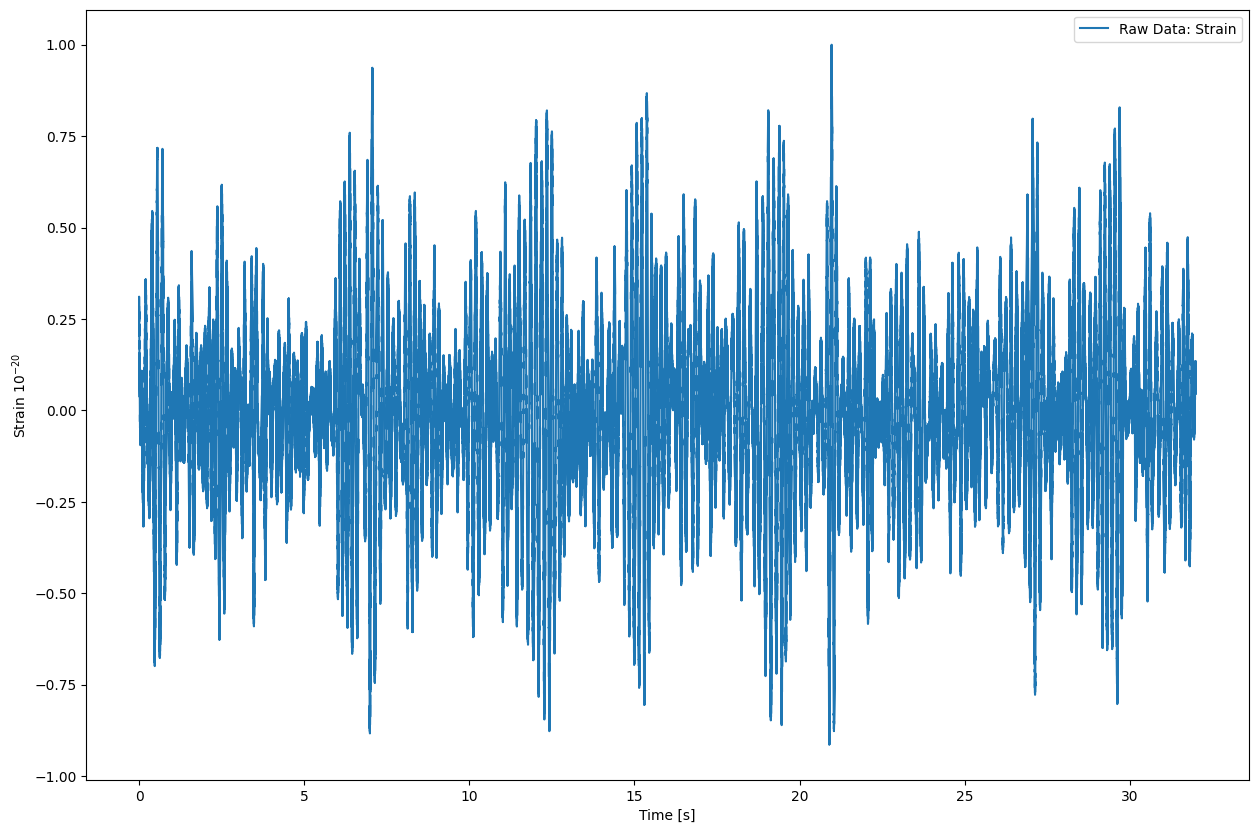

In [10]:
raw_strain, time = read_csv_file()
print(np.max((raw_strain)))
raw_strain = raw_strain/np.max(raw_strain)  #normalize the strain data, to avoid numerical error due to small number 1e-18
plt.plot(time, raw_strain, label="Raw Data: Strain")
plt.xlabel('Time [s]')
plt.ylabel(r'Strain $10^{-20}$')  
plt.legend()

### Frequency Domain

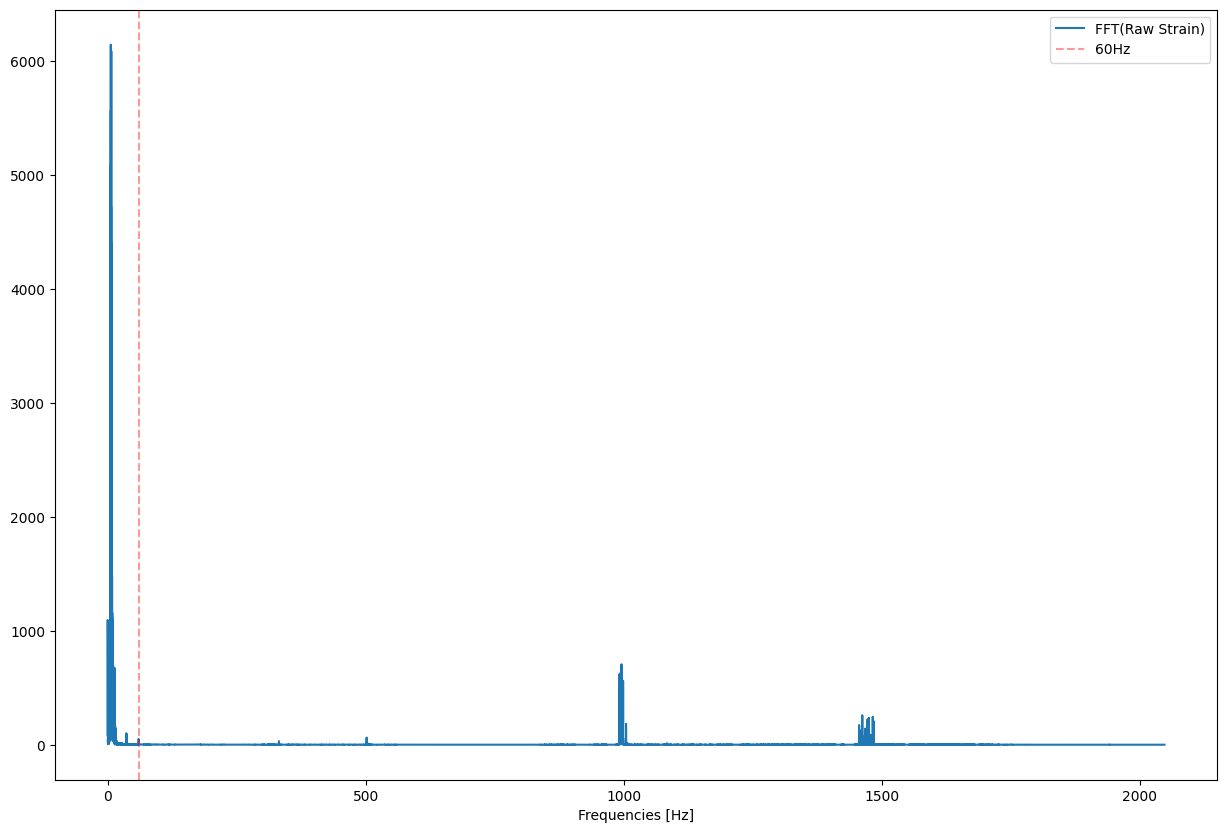

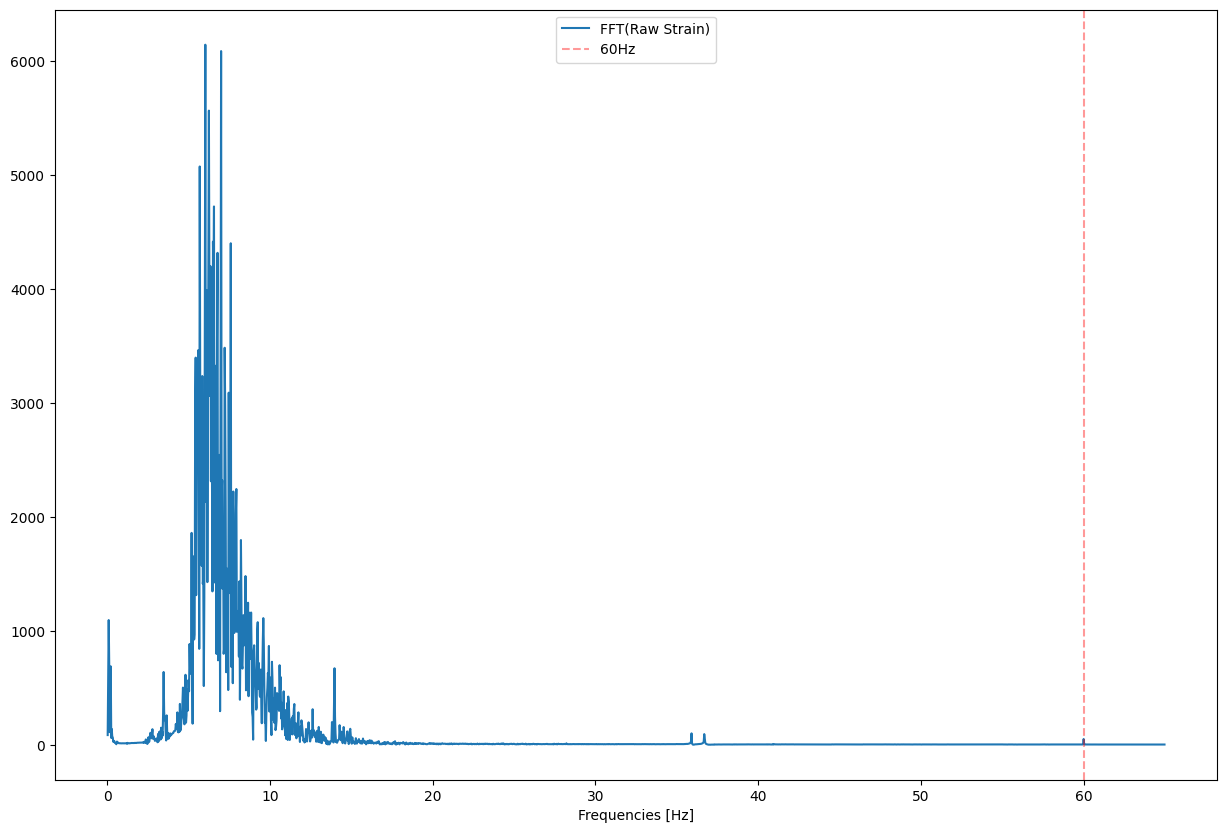

In [11]:
N = raw_strain.size
t_end = time[-1]
t_start = time[0]
f_s = N/(t_end-t_start)
spectrum, mag = get_fft(f_s, raw_strain)

plt.figure()
plt.plot(spectrum[(spectrum > 0)], mag[(spectrum > 0)], label="FFT(Raw Strain)")
plt.axvline(60, color = 'red', alpha = 0.4, linestyle ='--', label='60Hz')
plt.xlabel('Frequencies [Hz]')
plt.legend()

x = 60
plt.figure()
plt.plot(spectrum[(spectrum > 0) & (spectrum < x+5)], mag[(spectrum > 0) & (spectrum < x+5)], label="FFT(Raw Strain)")
plt.axvline(x, color = 'red', alpha = 0.4, linestyle ='--', label='60Hz')
plt.xlabel('Frequencies [Hz]')
plt.legend()

### Determining the Sampling Frequency

#Disregard this cell !

f_s = 1500*2*10  # where 10 is a "mickey-mouse" value
spectrum, mag = get_fft(f_s, raw_strain)
x = 60
f_max = 250
sub_x = spectrum[(spectrum < f_max) & (spectrum > 0)]
sub_y = mag[(spectrum < f_max) & (spectrum > 0)]
plt.plot(sub_x, sub_y, label=f"FFT(Raw Data) \n F_s = {f_s}")
plt.axvline(x, color = 'red', linestyle ='--', label='60Hz')
plt.legend()

### Notch Filter

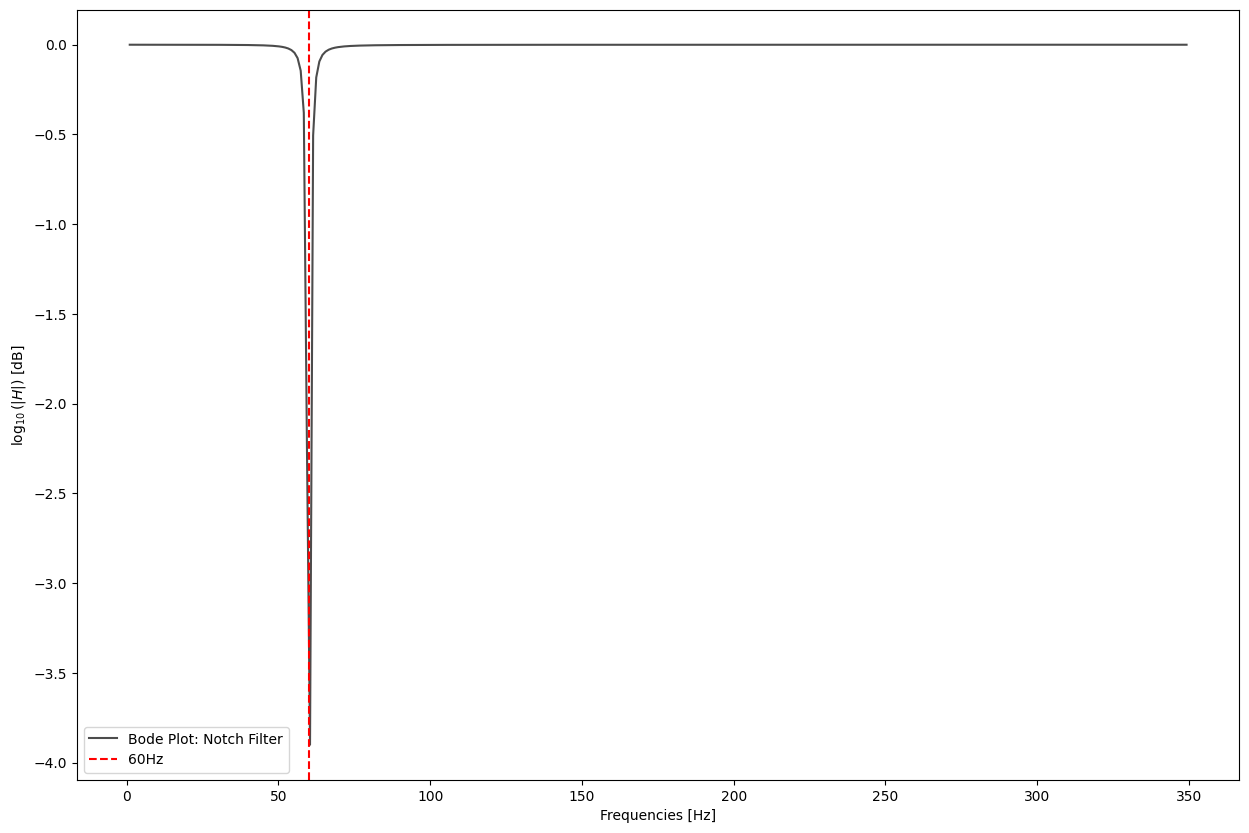

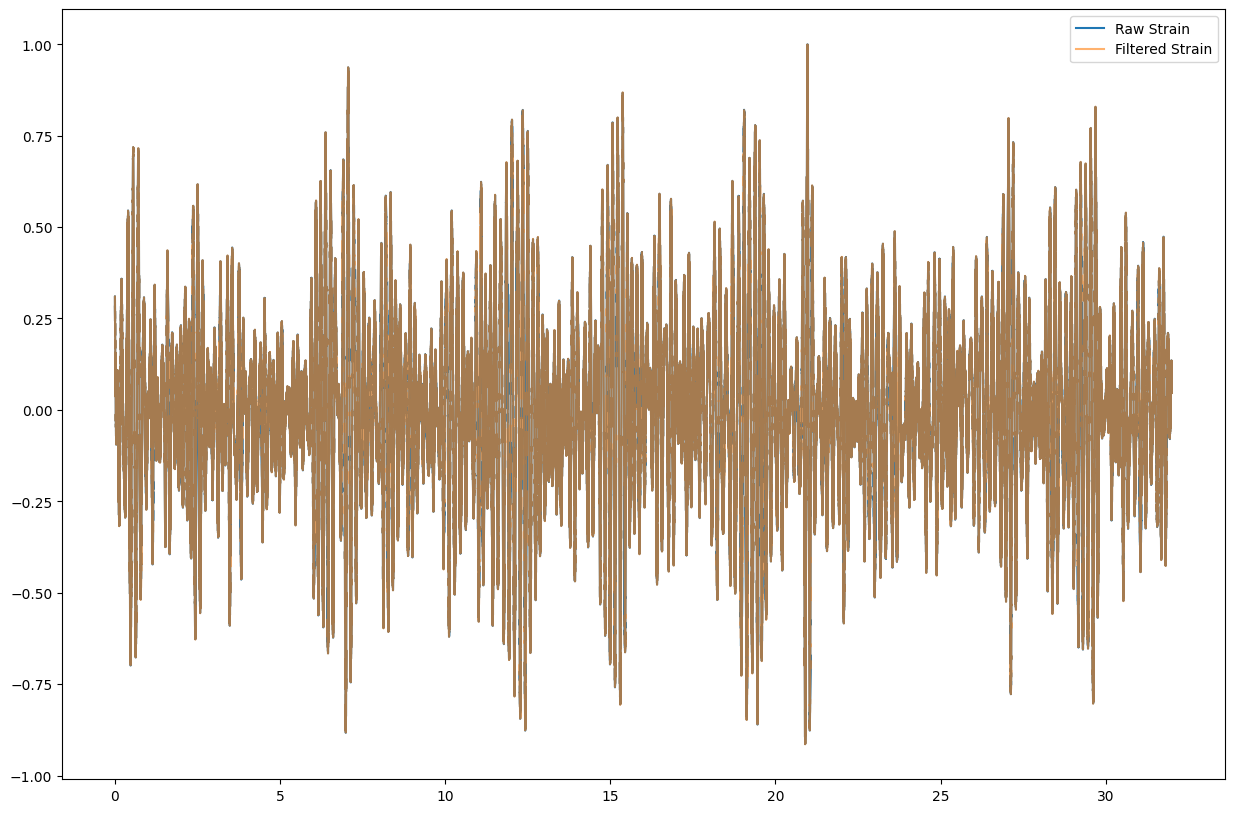

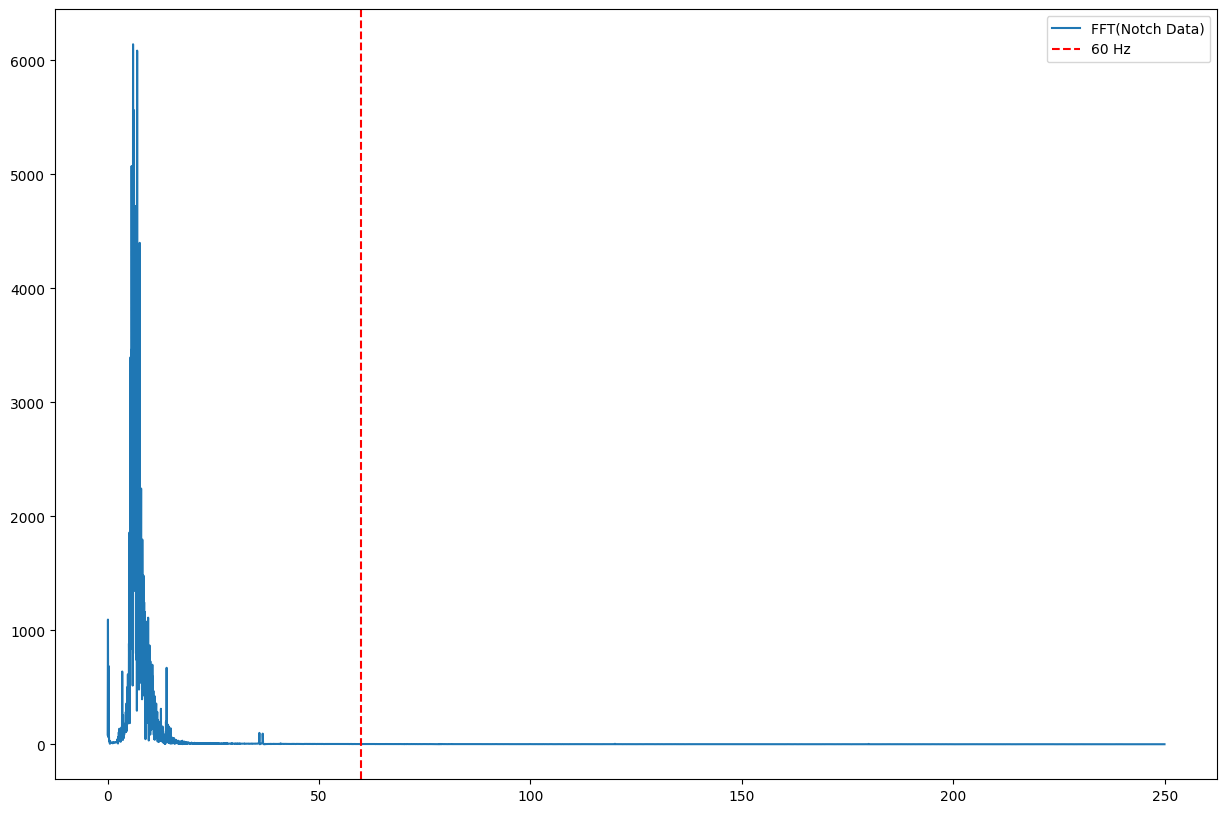

In [12]:
f_c = 60
f_max = 250
Q = 60
notch_strain, w, h = notch_filter(f_c, f_s, Q, raw_strain)
sub_x = w[(w < f_max+100) & (w > 0)]
sub_y = h[(w < f_max+100) & (w > 0)]

plt.plot(sub_x, sub_y, color='black', alpha=0.7, label='Bode Plot: Notch Filter' )
plt.axvline(f_c, color = 'red', linestyle ='--', label='60Hz')
plt.xlabel('Frequencies [Hz]')
plt.ylabel(r'$\log_{10}(|H|)$ [dB]')
plt.legend()

plt.figure()
plt.plot(time, raw_strain, alpha = 1, label='Raw Strain')
plt.plot(time, notch_strain, alpha = 0.6, label='Filtered Strain')
plt.legend()

spectrum, mag = get_fft(f_s, notch_strain)
x = 60
f_max = 250
sub_x = spectrum[(spectrum < f_max) & (spectrum > 0)]
sub_y = mag[(spectrum < f_max) & (spectrum > 0)]
plt.figure()
plt.plot(sub_x, sub_y, label="FFT(Notch Data)")
plt.axvline(x, color = 'red', linestyle ='--', label='60 Hz')
plt.legend()

### Notch Filtering 60*n Hz

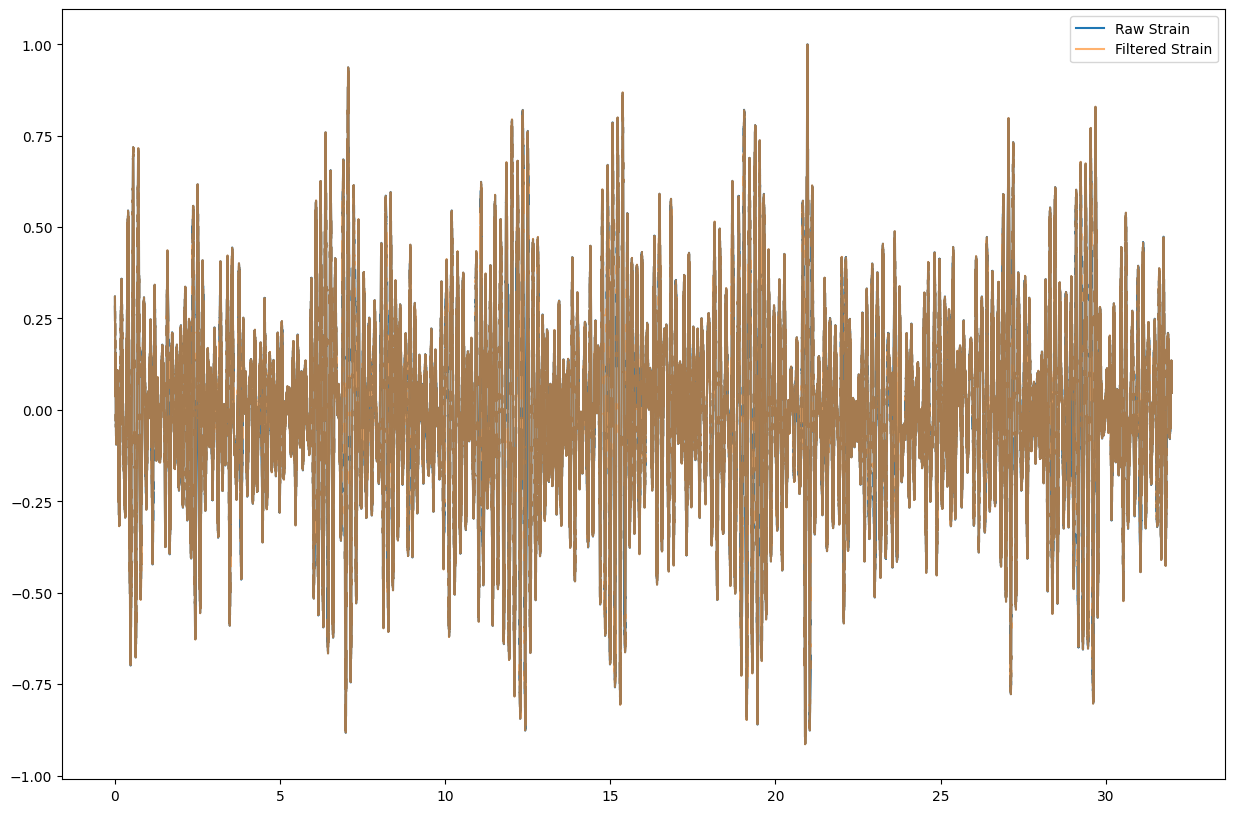

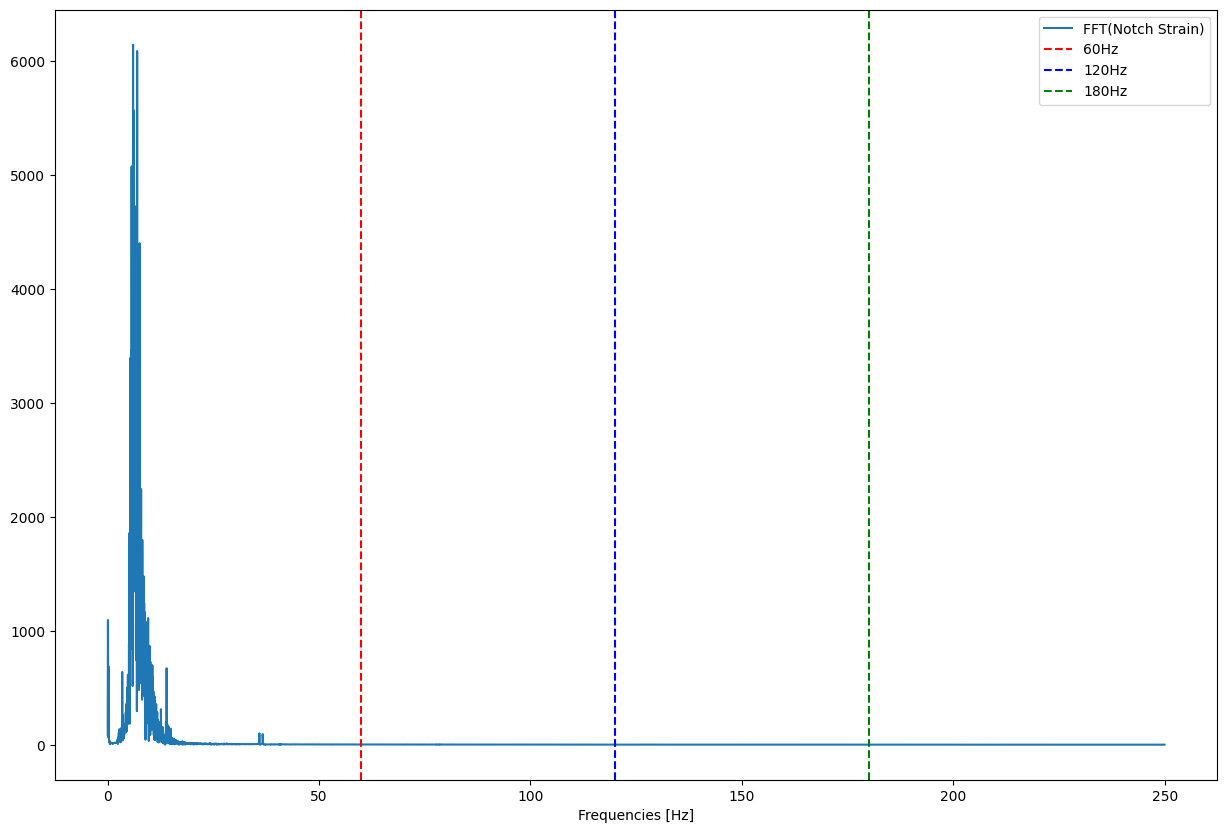

In [13]:
f_c = 60
Q = 60
notch_strain = notch_filter(f_c*2, f_s, Q, notch_strain)[0]
notch_strain = notch_filter(f_c*3, f_s, Q, notch_strain)[0]

plt.figure()
plt.plot(time, raw_strain, alpha = 1, label='Raw Strain')
plt.plot(time, notch_strain, alpha = 0.6, label='Filtered Strain')
plt.legend()

spectrum, mag = get_fft(f_s, notch_strain)
f_max = 250
sub_x = spectrum[(spectrum < f_max) & (spectrum > 0)]
sub_y = mag[(spectrum < f_max) & (spectrum > 0)]
plt.figure()
plt.plot(sub_x, sub_y, label="FFT(Notch Strain)")
plt.axvline(60, color = 'red', linestyle ='--', label='60Hz')
plt.axvline(60*2, color = 'blue', linestyle ='--', label='120Hz')
plt.axvline(60*3, color = 'green', linestyle ='--', label='180Hz')
plt.xlabel('Frequencies [Hz]')
plt.legend()

### Band Pass Filter

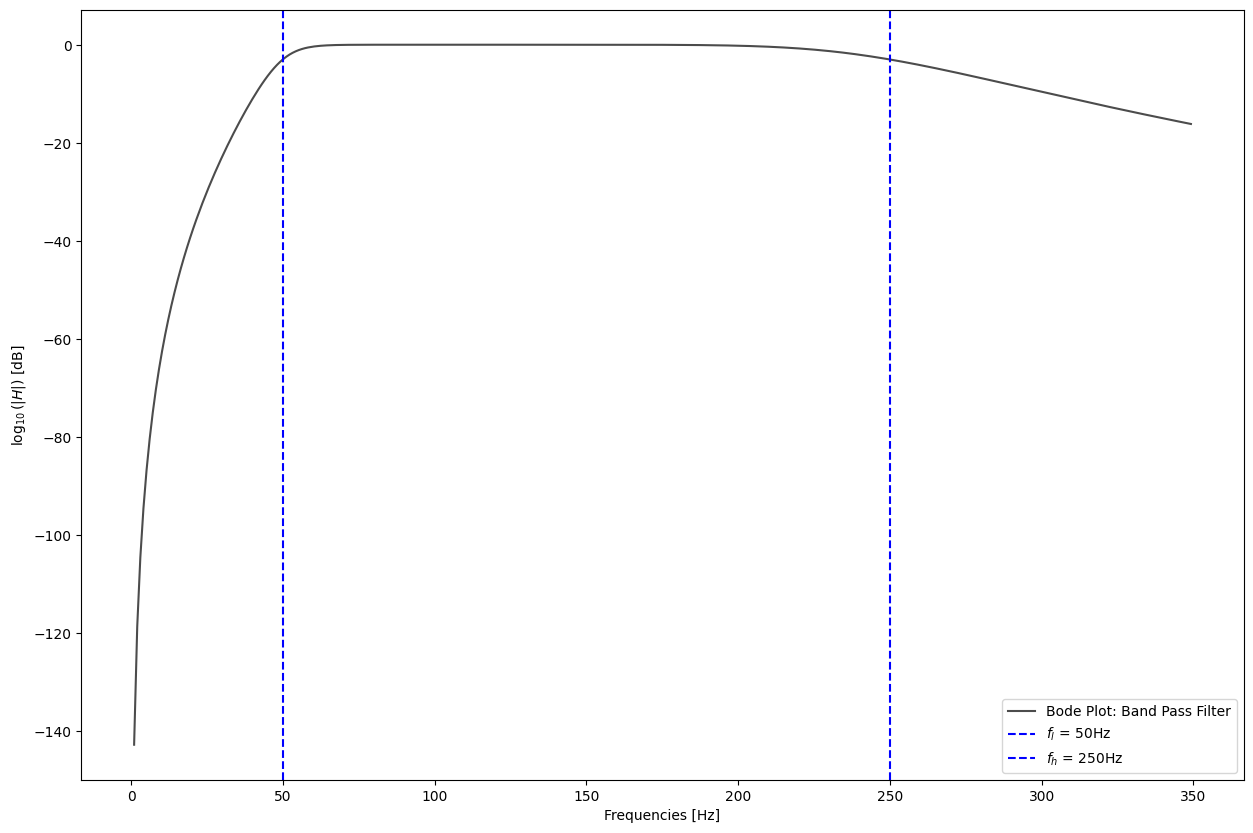

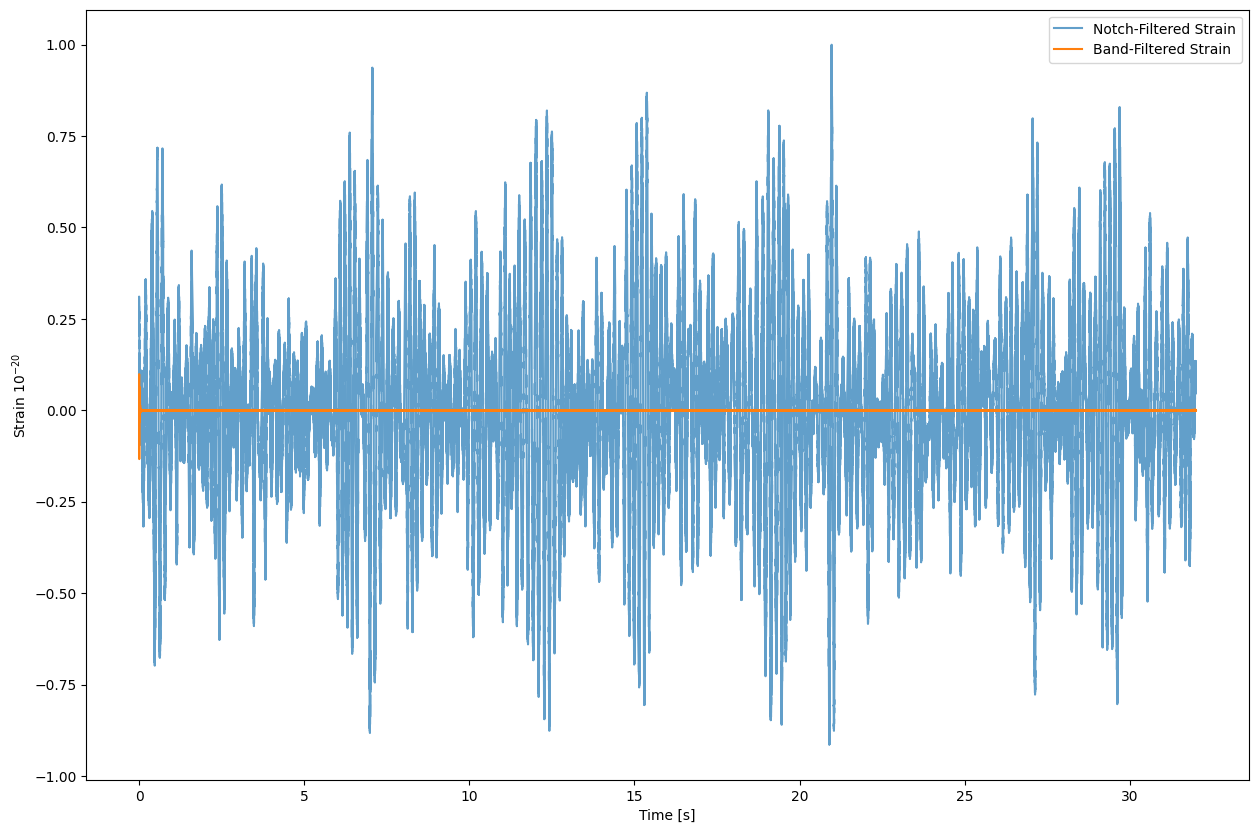

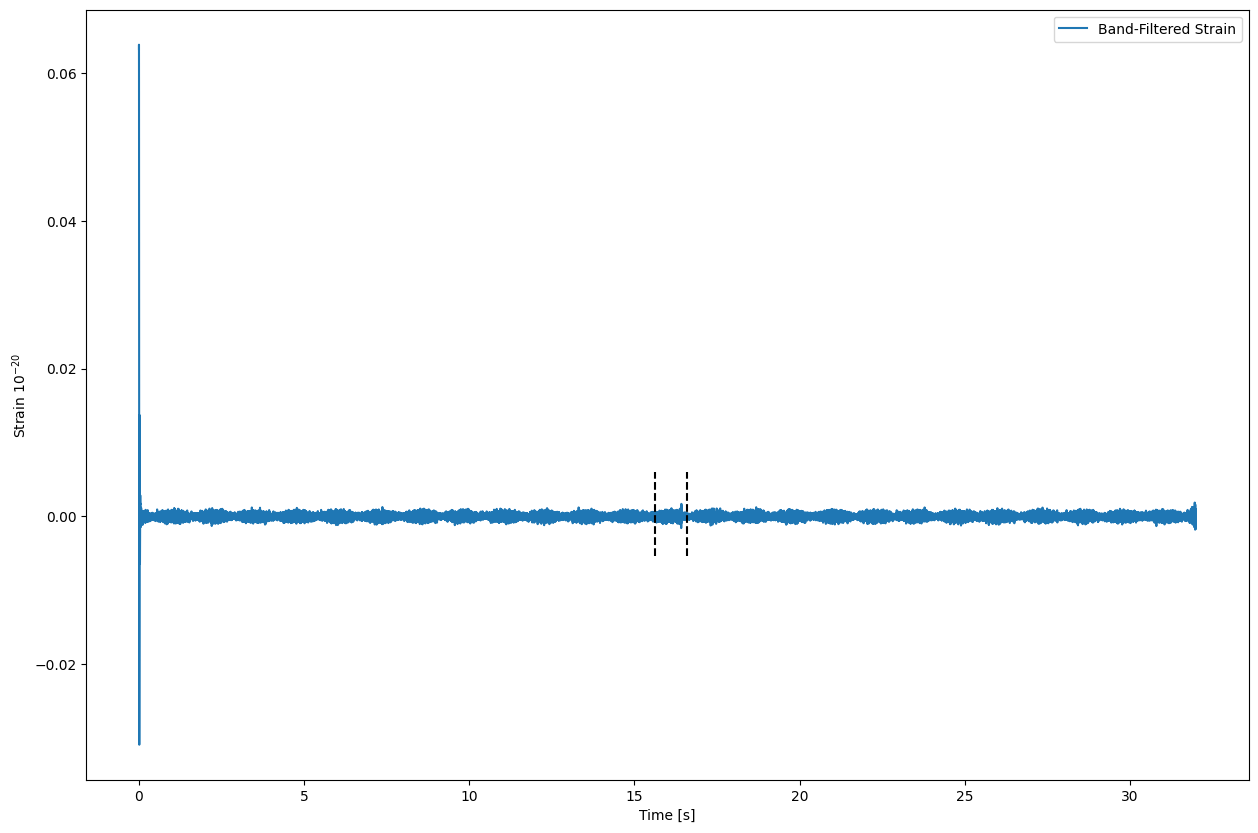

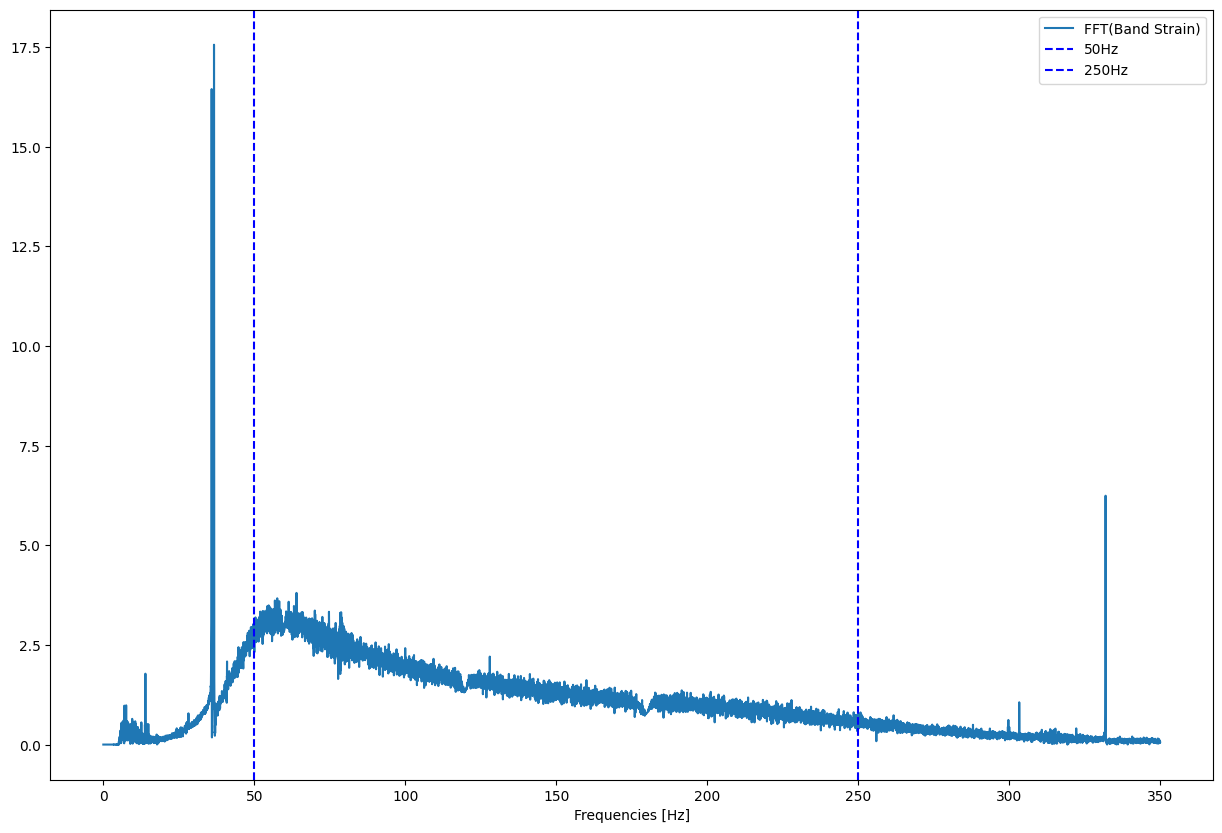

In [14]:
f_l = 50
f_h = 250
order = 4
ripple = 1
band_strain, w, h = band_pass_filter(order, ripple, f_l, f_h, f_s, notch_strain)
sub_x = w[(w < f_max+100) & (w > 0)]
sub_y = h[(w < f_max+100) & (w > 0)]
plt.plot(sub_x, sub_y, color='black', alpha=0.7, label='Bode Plot: Band Pass Filter' )
plt.axvline(f_l, color = 'blue', linestyle ='--', label=r'$f_{l}$ = 50Hz')
plt.axvline(f_h, color = 'blue', linestyle ='--', label=r'$f_{h}$ = 250Hz')
plt.xlabel('Frequencies [Hz]')
plt.ylabel(r'$\log_{10}(|H|)$ [dB]')
plt.legend()

plt.figure()
plt.plot(time, notch_strain, alpha = 0.7, label='Notch-Filtered Strain')
plt.plot(time, band_strain, alpha = 1, label='Band-Filtered Strain')
plt.xlabel('Time [s]')
plt.ylabel(r'Strain $10^{-20}$')  
plt.legend()


plt.figure()
plt.plot(time[50:-50], band_strain[50:-50], alpha = 1, label='Band-Filtered Strain')
plt.axvline(time[64000], color = 'black', linestyle ='--', ymax=0.4, ymin=0.29)
plt.axvline(time[68000], color = 'black', linestyle ='--', ymax=0.4, ymin=0.29)
plt.xlabel('Time [s]')
plt.ylabel(r'Strain $10^{-20}$')  
plt.legend()

# spectrum, mag_n = get_fft(f_s, notch_strain)
spectrum, mag_b = get_fft(f_s, band_strain)
f_max = 250+100
sub_x = spectrum[(spectrum < f_max) & (spectrum > 0)]
# sub_y_n = mag_n[(spectrum < f_max) & (spectrum > 0)]
sub_y_b = mag_b[(spectrum < f_max) & (spectrum > 0)]
plt.figure()
# plt.plot(sub_x, sub_y_n, alpha=1, label="FFT(Notch Data)")
plt.plot(sub_x, sub_y_b, alpha=1, label="FFT(Band Strain)")
plt.axvline(50, color = 'blue', linestyle ='--', label='50Hz')
plt.axvline(250, color = 'blue', linestyle ='--', label='250Hz')
plt.xlabel('Frequencies [Hz]')
plt.legend()



## Plot fft of band pass alone4
# cut away start of domain 

f_c = 52
Q = 50
final_strain = notch_filter(f_c, f_s, Q, band_strain)[0]

plt.figure()
plt.plot(time, band_strain, alpha = 1, label='Band Strain')
plt.plot(time, final_strain, alpha = 0.6, label='Final Strain')
plt.legend()

spectrum, mag_b = get_fft(f_s, band_strain)
spectrum, mag_f = get_fft(f_s, final_strain)
x = 60
f_max = 250+100
sub_x = spectrum[(spectrum < f_max) & (spectrum > 0)]
sub_y_b = mag_b[(spectrum < f_max) & (spectrum > 0)]
sub_y_f = mag_f[(spectrum < f_max) & (spectrum > 0)]
plt.figure()
plt.plot(sub_x, sub_y_b, alpha=1, label="FFT(Band Data)")
plt.plot(sub_x, sub_y_f, alpha=0.6, label="FFT(Final Data)")
plt.axvline(52, color = 'black', linestyle ='--', alpha = 0.65, label='52Hz')
plt.legend()

Text(0, 0.5, 'Strain $10^{-23}$')

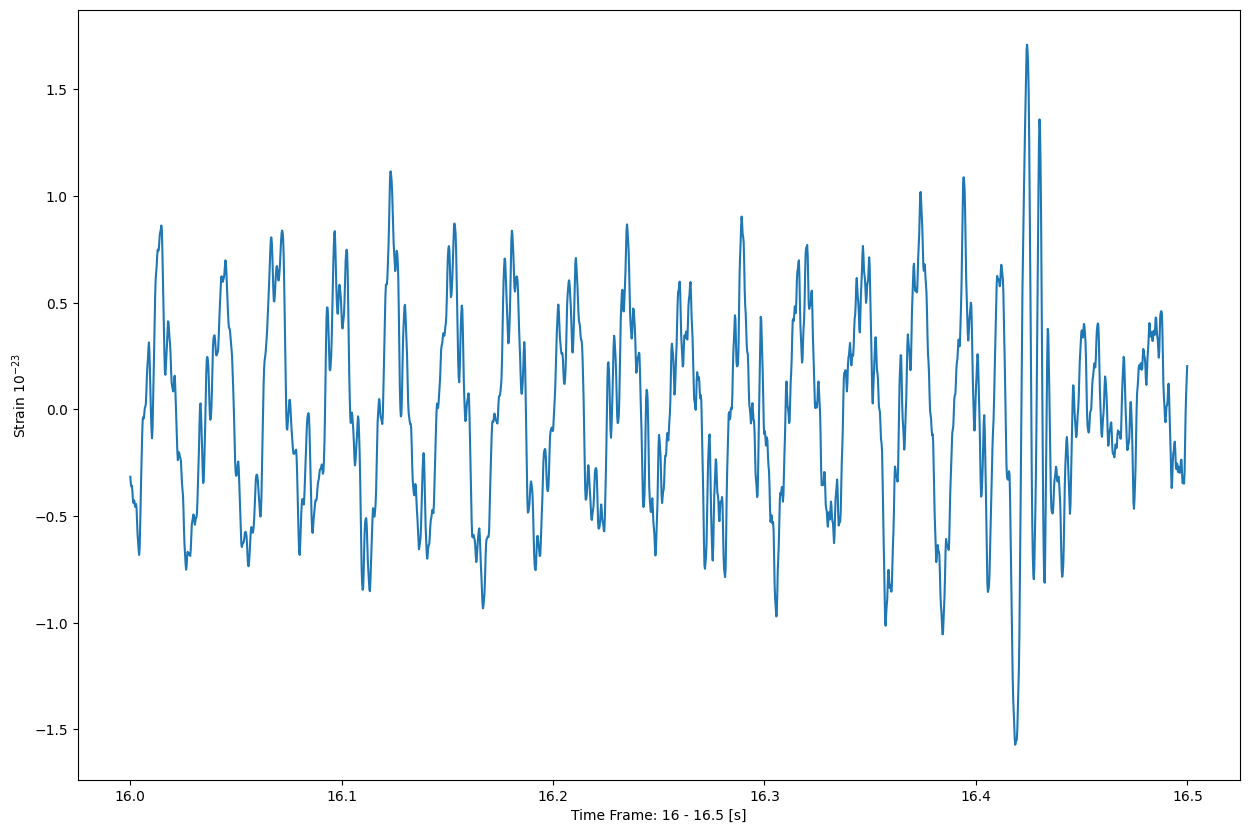

In [15]:
sub_x = time[(time>16) & (time<16.5)]
sub_y = band_strain[(time>16) & (time<16.5)]/1e-3
plt.figure()
plt.plot(sub_x, sub_y, alpha = 1, label='Filtered Strain')
plt.xlabel('Time Frame: 16 - 16.5 [s]')
plt.ylabel(r'Strain $10^{-23}$')  